# Can We Predict Political Stability Through Use of Global Sustainability Goal Indicators? 

In 2015, all UN Member States developed a set of 17 Global Sustainability Goals to allow for peace and prosperity globally.  The set of goals include those to reduce poverity and inequality, improve health and education, increase economic growth, increase access to clean water and food, and do so in a manner that protects the land and oceans.  

Climate change induced floods and droughts, poverity, and lack of access to clean water and food all contribute to political tension and violence as people struggle to meet their basic needs.  The goal of this project is to see how well the country status of each sustainable development goal can be used to predict the political stability and absence of violence for each country. 

The Sustainability Goals data were obtained from World Bank:https://api.worldbank.org/v2/sources/46/indicators
Documentation on the Sustainability Goals can be found here: https://datatopics.worldbank.org/sdgatlas/
The Worldwide Governance Indicators data were obtaiend from World Bank: https://datacatalog.worldbank.org/dataset/worldwide-governance-indicators.  Details on the selected variables from each dataset can be found below. 



## Get Response Variable: Political Stability and Absence of Violence/Terrorism

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import datetime
import wbdata
import plotly.express as px
import plotly.io as pio
import requests
import psycopg2

In [2]:
# Connecting to the database (set a new connection)
conn = psycopg2.connect("dbname=sustain_data user=postgres password=CLS521")
cursor = conn.cursor
sql = "select * from instability_df;"
query_results = pd.read_sql_query(sql, conn)
PT_new_df = pd.DataFrame(query_results)
conn = None

In [3]:
PT_new_df.head()

,id,country,date,political_stability,political_stability_se,lat,lon
0,ABW,Aruba,2019,1.357372,0.271196,12.4903,-69.960984
1,ABW,Aruba,2018,1.362981,0.251480,12.4903,-69.960984
2,ABW,Aruba,2017,1.334757,0.254837,12.4903,-69.960984
3,ABW,Aruba,2016,1.284199,0.244329,12.4903,-69.960984
4,ABW,Aruba,2015,1.230921,0.241163,12.4903,-69.960984


In [4]:
#Change df column names for easier processing
PT_new_df.rename(columns={"political_stability": "Political_Stability", "political_stability_se": "Political_Stability_SE", "id_x": "id"}, inplace=True)
PT_new_df.head()

,id,country,date,Political_Stability,Political_Stability_SE,lat,lon
0,ABW,Aruba,2019,1.357372,0.271196,12.4903,-69.960984
1,ABW,Aruba,2018,1.362981,0.251480,12.4903,-69.960984
2,ABW,Aruba,2017,1.334757,0.254837,12.4903,-69.960984
3,ABW,Aruba,2016,1.284199,0.244329,12.4903,-69.960984
4,ABW,Aruba,2015,1.230921,0.241163,12.4903,-69.960984


In [5]:
#Find the 10 year mean political stability of each country
grouped_PT_df = PT_new_df.groupby('country').mean().reset_index()
grouped_PT_df[grouped_PT_df['country']=='United States']

,country,date,Political_Stability,Political_Stability_SE,lat,lon
196,United States,2014.5,0.507555,0.216898,39.78373,-100.445882


In [6]:
grouped_PT_df.drop('date', axis=1, inplace=True)

In [7]:
grouped_PT_df[grouped_PT_df['country']=='United States']

,country,Political_Stability,Political_Stability_SE,lat,lon
196,United States,0.507555,0.216898,39.78373,-100.445882


# Remove any Countries with High Standard Error for Estimates of Political Stability

Countries that have a high standard error for estimates of political stability have low precision of the estimate of governance.  Larger values of the standard error indicate less precise estimates.  A 90 percent confidence interval for the governance estimate is given by the estimate +/- 1.64 times the standard error.  We only want to include countries that have precise estimates for political stability because we want our model to use measures of global sustainability indicators to predict the countries actual political stability. 

In [8]:
#Remove any outliers for high Standard Error
# calculate summary statistics
data_mean, data_std = np.mean(PT_new_df['Political_Stability_SE']), np.std(PT_new_df['Political_Stability_SE'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower, upper)

0.05732021248656441 0.43429947787725076


In [9]:
# remove outliers with standard error higher than three standard deviations about the mean standard error
PT_new_df = PT_new_df[(PT_new_df['Political_Stability_SE'] < upper)]

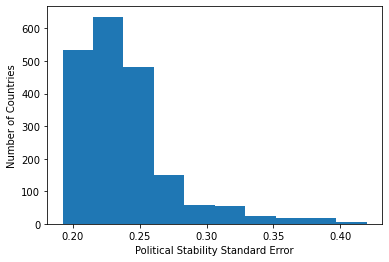

In [10]:
#plot histogram of the Standard Error
import matplotlib.pyplot as plt

plt.hist(PT_new_df['Political_Stability_SE'])
PT_new_df['Political_Stability_SE'].describe()
plt.xlabel("Political Stability Standard Error")
plt.ylabel("Number of Countries")
plt.show()

The dataset now only includes countries with max standard error in the dataset of 0.42.

In [11]:
#Sort the dataset on the 10 year mean political stability values from highest to lowest
grouped_PT_df.sort_values('Political_Stability', ascending=False)

,country,Political_Stability,Political_Stability_SE,lat,lon
71,Greenland,1.903959,0.382400,77.619235,-42.812597
105,Liechtenstein,1.480630,0.269135,47.141631,9.553153
132,New Zealand,1.457606,0.216898,-41.500083,172.834408
91,"Jersey, Channel Islands",1.399630,0.485580,49.185217,-2.109048
163,Singapore,1.374209,0.216898,1.357107,103.819499
...,...,...,...,...,...
85,Iraq,-2.247403,0.231976,33.095579,44.174977
179,Syrian Arab Republic,-2.490038,0.229933,34.640186,39.049411
140,Pakistan,-2.504352,0.220594,30.330840,71.247499
0,Afghanistan,-2.587409,0.238639,33.768006,66.238514


The top five countries with high political stability estimates are Greenland, Liechtenstein, New Zealand, Jersey, Channel Islands, and Singapore.  The lowest political stability estimates are Iraq, Syrian Arab Republic, Pakistan, Afghanistan and Somalia. 

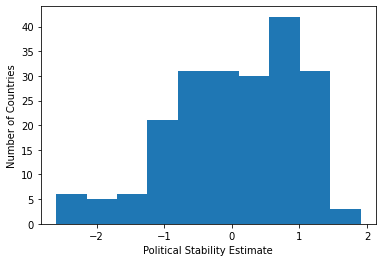

In [12]:
#Show a histogram of 5-year mean political stability. 
plt.hist(x="Political_Stability", data=grouped_PT_df)
plt.xlabel("Political Stability Estimate")
plt.ylabel("Number of Countries")
plt.show()

# Graph the Political Stability Values on a Map

In [13]:
#Change names of several countries to match the country name listed in the geopandas shapefile
modified_country_df = grouped_PT_df
boolean_condition = grouped_PT_df.country == 'United States'
column_name = 'country'
new_value = 'United States of America'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Russian Federation'
column_name = 'country'
new_value = 'Russia'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Venezuela, RB'
column_name = 'country'
new_value = 'Venezuela'
modified_country_df.loc[boolean_condition, column_name] = new_value

boolean_condition = grouped_PT_df.country == 'Syrian Arab Republic'
column_name = 'country'
new_value = 'Syria'
modified_country_df.loc[boolean_condition, column_name] = new_value

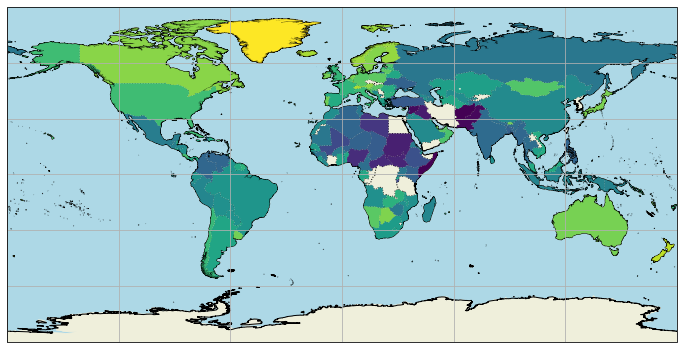

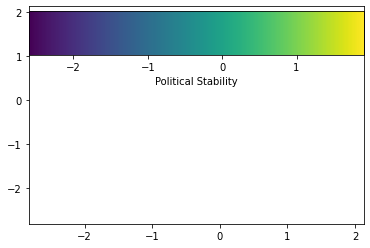

In [14]:
import cartopy
from cartopy.io import shapereader
import cartopy.crs as ccrs
import geopandas
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'
shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# Set up the canvas
fig = plt.figure(figsize=(12, 12))
central_lon = 0 
ax = plt.axes(projection=cartopy.crs.PlateCarree(central_lon))
ax.gridlines()

# Add borders, ocean, and land features
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1)
ax.add_feature(cartopy.feature.OCEAN, facecolor=("lightblue"))
ax.add_feature(cartopy.feature.LAND)
ax.coastlines(resolution='10m')

# Define the list of countries we want to map
countries = modified_country_df['country']

#Define the political stability values for each country
ps = modified_country_df['Political_Stability']

# Normalise the political stability values to between 0 and 1 to extract the colour
ps_norm = (ps-np.nanmin(ps))/(np.nanmax(ps) - np.nanmin(ps))

# Choose the colormap
cmap = plt.cm.get_cmap('viridis')

#loop through each country and political stability value and plot them
for country, ps_norm in zip(countries, ps_norm):
    # read the borders of the country in this loop
    #Exclude some countries whose names are not in the geopandas shapefile
    exclude_list = ['Bahamas, The', 'Brunei Darussalam', "Cote d'Ivoire", "Czech Republic", "Eswatini", "French Guiana", "Gambia, The", "Hong Kong SAR, China", "Jersey, Channel Islands", "Kyrgyz Republic", "Lao PDR", "Macao SAR, China", "Martinique", "Netherlands Antilles", "North Macedonia", "Reunion", "Sao Tome and Principe", "Serbia", "Slovak Republic", "St. Kitts and Nevis", "St. Lucia", "St. Vincent and the Grenadines", "Taiwan, China", "Tanzania", "Timor-Leste", "Virgin Islands (U.S.)", "West Bank and Gaza"]
    if country not in exclude_list:
        poly = df.loc[df['ADMIN'] == country]['geometry'].values[0]
        # get the color for this country
        rgba = cmap(ps_norm)
        # plot the country on a map
        ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor=rgba, edgecolor='none', zorder=1)

# Add a scatter plot of the original data so the colorbar has the correct numbers.
#fig, ax = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [2, 1]})
fig, ax = plt.subplots()

dummy_scat = ax.scatter(ps, ps, c=ps, cmap=cmap, zorder=0)
dummy_scat.set_visible(False)
axins1 = inset_axes(ax,
                    width="100%",  
                    height="20%", 
                    loc='upper center')
fig.colorbar(mappable=dummy_scat, label='Political Stability', orientation='horizontal', cax=axins1)
  

In [15]:
#Try to find the name of the countries in the shapefile that are in the exclude list above
newdf = df.loc[(df.ADMIN == "Gaza")]
newdf.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry


# Get Predictor Variables from Sustainability Goals Dataset

In [16]:
#Set a list of all the predictor variables that we want to use from the dataset. 
predictor_variables = []

In [17]:
# Connecting to the database (set a new connection)
conn = psycopg2.connect("dbname=sustain_data user=postgres password=CLS521")
cursor = conn.cursor
sql = "select * from sus_df;"
query_results = pd.read_sql_query(sql, conn)
DF_data = pd.DataFrame(query_results)
conn = None

In [18]:
DF_data.head()

,country,date,forest_area,cereal_yield,current_account_balance,foreign_direct_investment,net_assistance_and_aid,access_clean_fuels,access_electricity,renewable_electricity_output,...,female_genital_mutilation_prevalence,prevalence_underweight_children_under_five,suicide_mortality_rate,high_health_care_expenditure,unemployment,moderate_severe_food_insecurity,women_married_by_age_18,urban_population_growth,battle_related_deaths,intentional_homicides_per_pop
0,Arab World,2019,NaN,NaN,NaN,1.278438,NaN,NaN,89.512282,NaN,...,NaN,NaN,4.180325,NaN,10.207223,NaN,NaN,2.385471,NaN,NaN
1,Arab World,2018,2.849036,2011.461649,NaN,1.258055,NaN,NaN,88.306324,NaN,...,NaN,NaN,4.212684,NaN,10.256579,NaN,NaN,2.414030,20934.0,NaN
2,Arab World,2017,2.868595,1869.677439,NaN,1.230380,NaN,NaN,89.623427,NaN,...,NaN,NaN,4.179462,NaN,10.718294,NaN,NaN,2.473679,37279.0,NaN
3,Arab World,2016,2.887384,1705.274933,NaN,1.360062,NaN,84.510733,88.504261,NaN,...,NaN,NaN,4.258030,NaN,10.507661,NaN,NaN,2.576060,58959.0,NaN
4,Arab World,2015,2.904999,2057.438839,NaN,1.043033,NaN,84.171596,87.935479,2.920702,...,NaN,NaN,4.333516,NaN,10.713793,NaN,NaN,2.695668,68181.0,3.8


In [19]:
DF_data.set_index(['country', 'date'], inplace=True)

In [20]:
print(DF_data.columns.values.tolist())

['forest_area', 'cereal_yield', 'current_account_balance', 'foreign_direct_investment', 'net_assistance_and_aid', 'access_clean_fuels', 'access_electricity', 'renewable_electricity_output', 'co2_emissions', 'air_pollution', 'mammal_species_threatened', 'population_in_slums', 'water_stress', 'renewable_freshwater_resources', 'terrestrial_protected_areas', 'commercial_bank_branches', 'broad_money_growth', 'inflation', 'account_ownership_financial_institution', 'account_ownership_financial_institution_female', 'research_development_expenditure', 'new_business_density', 'investment_in_energy', 'investment_in_clean_water', 'individuals_using_internet', 'exports_of_goods_annual_growth', 'exports_of_goods', 'imports_of_goods_annual_growth', 'gdp', 'gdp_growth', 'gdp_per_capita', 'gdp_per_capita_growth', 'literacy_rate_youth_female', 'literacy_rate_adult_total', 'school_enrollment_preprimary', 'school_enrollment_primary_and_secondary_gpi', 'lower_secondary_completion_rate', 'educational_attain

In [21]:
list1 = []
def list_cols(df, listx):
    for col in df.columns:
        listx.append(col)
    return listx

In [22]:
list_cols(DF_data, list1)

['forest_area',
 'cereal_yield',
 'current_account_balance',
 'foreign_direct_investment',
 'net_assistance_and_aid',
 'access_clean_fuels',
 'access_electricity',
 'renewable_electricity_output',
 'co2_emissions',
 'air_pollution',
 'mammal_species_threatened',
 'population_in_slums',
 'water_stress',
 'renewable_freshwater_resources',
 'terrestrial_protected_areas',
 'commercial_bank_branches',
 'broad_money_growth',
 'inflation',
 'account_ownership_financial_institution',
 'account_ownership_financial_institution_female',
 'research_development_expenditure',
 'new_business_density',
 'investment_in_energy',
 'investment_in_clean_water',
 'individuals_using_internet',
 'exports_of_goods_annual_growth',
 'exports_of_goods',
 'imports_of_goods_annual_growth',
 'gdp',
 'gdp_growth',
 'gdp_per_capita',
 'gdp_per_capita_growth',
 'literacy_rate_youth_female',
 'literacy_rate_adult_total',
 'school_enrollment_preprimary',
 'school_enrollment_primary_and_secondary_gpi',
 'lower_secondary_c

In [23]:
list2 = ['Forest area (% of land area)',
 'Cereal yield (kg per hectare)',
 'Current account balance (% of GDP)',
 'Foreign direct investment, net inflows (% of GDP)',
 'Net official development assistance and official aid received (current US$)',
 'Access to clean fuels and technologies for cooking (% of population)',
 'Access to electricity (% of population)',
 'Renewable electricity output (% of total electricity output)',
 'CO2 emissions (metric tons per capita)',
 'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
 'Mammal species, threatened',
 'Population living in slums (% of urban population)',
 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
 'Renewable internal freshwater resources per capita (cubic meters)',
 'Terrestrial protected areas (% of total land area)',
 'Commercial bank branches (per 100,000 adults)',
 'Broad money growth (annual %)',
 'Inflation, consumer prices (annual %)',
 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)',
 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
 'Research and development expenditure (% of GDP)',
 'New business density (new registrations per 1,000 people ages 15-64)',
 'Investment in energy with private participation (current US$)',
 'Investment in water and sanitation with private participation (current US$)',
 'Individuals using the Internet (% of population)',
 'Exports of goods and services (annual % growth)',
 'Exports of goods and services (% of GDP)',
 'Imports of goods and services (annual % growth)',
 'GDP (current US$)',
 'GDP growth (annual %)',
 'GDP per capita (current US$)',
 'GDP per capita growth (annual %)',
 'Literacy rate, youth female (% of females ages 15-24)',
 'Literacy rate, adult total (% of people ages 15 and above)',
 'School enrollment, preprimary (% gross)',
 'School enrollment, primary and secondary (gross), gender parity index (GPI)',
 'Lower secondary completion rate, total (% of relevant age group)',
 'Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)',
 "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",
 'Adolescents out of school (% of lower secondary school age)',
 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
 'Prevalence of anemia among women of reproductive age (% of women ages 15-49)',
 'Prevalence of HIV, total (% of population ages 15-49)',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)',
 'Mortality rate, neonatal (per 1,000 live births)',
 'People using at least basic drinking water services (% of population)',
 'People using safely managed drinking water services (% of population)',
 'Female genital mutilation prevalence (%)',
 'Prevalence of underweight, weight for age (% of children under 5)',
 'Suicide mortality rate (per 100,000 population)',
 'Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%)',
 'Unemployment, total (% of total labor force) (modeled ILO estimate)',
 'Prevalence of moderate or severe food insecurity in the population (%)',
 'Women who were first married by age 18 (% of women ages 20-24)',
 'Urban population growth (annual %)',
 'Battle-related deaths (number of people)',
 'Intentional homicides (per 100,000 people)']

In [24]:
dict_cols = {}
def create_dict(keys, vals):
    for key in keys:
        for value in vals:
            dict_cols[key] = value
            vals.remove(value)
            break 

In [25]:
create_dict(list1, list2)

In [26]:
dict_cols

{'forest_area': 'Forest area (% of land area)',
 'cereal_yield': 'Cereal yield (kg per hectare)',
 'current_account_balance': 'Current account balance (% of GDP)',
 'foreign_direct_investment': 'Foreign direct investment, net inflows (% of GDP)',
 'net_assistance_and_aid': 'Net official development assistance and official aid received (current US$)',
 'access_clean_fuels': 'Access to clean fuels and technologies for cooking (% of population)',
 'access_electricity': 'Access to electricity (% of population)',
 'renewable_electricity_output': 'Renewable electricity output (% of total electricity output)',
 'co2_emissions': 'CO2 emissions (metric tons per capita)',
 'air_pollution': 'PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)',
 'mammal_species_threatened': 'Mammal species, threatened',
 'population_in_slums': 'Population living in slums (% of urban population)',
 'water_stress': 'Level of water stress: freshwater withdrawal as a proportio

In [27]:
def rename_cols(df, dictx):
    df.rename(columns=dictx, inplace=True)    

In [28]:
rename_cols(DF_data, dict_cols)

In [29]:
DF_data.head()

Forest area (% of land area)  Cereal yield (kg per hectare)  \
country    date                                                                
Arab World 2019                           NaN                            NaN   
           2018                      2.849036                    2011.461649   
           2017                      2.868595                    1869.677439   
           2016                      2.887384                    1705.274933   
           2015                      2.904999                    2057.438839   

                 Current account balance (% of GDP)  \
country    date                                       
Arab World 2019                                 NaN   
           2018                                 NaN   
           2017                                 NaN   
           2016                                 NaN   
           2015                                 NaN   

                 Foreign direct investment, net inflows (% of GDP)  \
country    date                                                      
Arab World 2019                                           1.278438   
           2018                                           1.258055   
           2017                                           1.230380   
           2016                                           1.360062   
           2015                                           1.043033   

                 Net official development assistance and official aid received (current US$)  \
country    date                                                                                
Arab World 2019                                                NaN                             
           2018                                                NaN                             
           2017                                                NaN                             
           2016                                                NaN                             
           2015                                                NaN                             

                 Access to clean fuels and technologies for cooking (% of population)  \
country    date                                                                         
Arab World 2019                                                NaN                      
           2018                                                NaN                      
           2017                                                NaN                      
           2016                                          84.510733                      
           2015                                          84.171596                      

                 Access to electricity (% of population)  \
country    date                                            
Arab World 2019                                89.512282   
           2018                                88.306324   
           2017                                89.623427   
           2016                                88.504261   
           2015                                87.935479   

                 Renewable electricity output (% of total electricity output)  \
country    date                                                                 
Arab World 2019                                                NaN              
           2018                                                NaN              
           2017                                                NaN              
           2016                                                NaN              
           2015                                           2.920702              

                 CO2 emissions (metric tons per capita)  \
country    date                                           
Arab World 2019                                     NaN   
           2018                                4.438716   
           2017                                4.528351  

## Merging Political Stability and Sustainability Goals Dataframes

In [30]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [31]:
#Use pd.merge to do an inner join of political and sustainability DFs on "country" and "date".
merged_inner = pd.merge(left=DF_data, right=PT_new_df, on=['country', 'date'])
#Since it's an inner join, this automatically removes rows for which the country/date pairs don't appear in both tables.  

print(merged_inner.shape)
merged_inner.head()

(1927, 65)


,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,2019,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,2018,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0

In [32]:
merged_inner.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1927 entries, 0 to 1926
Data columns (total 65 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype  
---  ------                                                                                                                           --------------  -----  
 0   country                                                                                                                          1927 non-null   object 
 1   date                                                                                                                             1927 non-null   int64  
 2   Forest area (% of land area)                                                                                                     1703 non-null   float64
 3   Cereal yield (kg per hectare)                                                                     

### Preprocessing

In [33]:
#Convert "date" column from string object to datetime format.
merged_inner["date"] = pd.to_datetime(merged_inner["date"])
merged_inner.head()

,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,1970-01-01 00:00:00.000002019,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,1970-01-01 00:00:00.000002018,1.850994,2164.9,-21.231682,0.65073

In [34]:
#Convert "date" column to only show year.
import datetime as dt
merged_inner["date"]=merged_inner["date"].dt.year
merged_inner.head()

,country,date,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",id,Political_Stability,Political_Stability_SE,lat,lon
0,Afghanistan,1970,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,AFG,-2.649407,0.241833,33.768006,66.238514
1,Afghanistan,1970,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0

In [35]:
country_count = merged_inner['country'].nunique()
print(country_count)
country_list = merged_inner['country'].unique()
print(country_list)

194
['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Comoros' 'Costa Rica' "Cote d'Ivoire" 'Croatia'
 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia, The' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Greenland'
 'Grenada' 'Guam' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'Honduras' 'Hong Kong SAR, China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iraq' 'Ireland' 'Israe

In [36]:
#Convert "country" column from regular string object to categorical.
country_labels = merged_inner['country'].astype('category').cat.categories.tolist()

#create map/dictionary for label encoding.
replace_map_country = {'country' : {k: v for k,v in zip(country_labels,list(range(1,len(country_labels)+1)))}}

print(replace_map_country)

{'country': {'Afghanistan': 1, 'Albania': 2, 'Algeria': 3, 'American Samoa': 4, 'Andorra': 5, 'Angola': 6, 'Antigua and Barbuda': 7, 'Argentina': 8, 'Armenia': 9, 'Aruba': 10, 'Australia': 11, 'Austria': 12, 'Azerbaijan': 13, 'Bahamas, The': 14, 'Bahrain': 15, 'Bangladesh': 16, 'Barbados': 17, 'Belarus': 18, 'Belgium': 19, 'Belize': 20, 'Benin': 21, 'Bermuda': 22, 'Bhutan': 23, 'Bolivia': 24, 'Bosnia and Herzegovina': 25, 'Botswana': 26, 'Brazil': 27, 'Brunei Darussalam': 28, 'Bulgaria': 29, 'Burkina Faso': 30, 'Burundi': 31, 'Cabo Verde': 32, 'Cambodia': 33, 'Cameroon': 34, 'Canada': 35, 'Cayman Islands': 36, 'Central African Republic': 37, 'Chad': 38, 'Chile': 39, 'China': 40, 'Colombia': 41, 'Comoros': 42, 'Costa Rica': 43, "Cote d'Ivoire": 44, 'Croatia': 45, 'Cuba': 46, 'Cyprus': 47, 'Czech Republic': 48, 'Denmark': 49, 'Djibouti': 50, 'Dominica': 51, 'Dominican Republic': 52, 'Ecuador': 53, 'El Salvador': 54, 'Equatorial Guinea': 55, 'Eritrea': 56, 'Estonia': 57, 'Eswatini': 58, '

In [37]:
#Create a copy of the merged_inner df so that we still have a version with country names and IDs.
merged_encoded = merged_inner.copy()

In [38]:
#Label encode all countries by mapping the corresponding dictionary values (integers) onto the keys (country names).
merged_encoded.replace(replace_map_country, inplace=True)

In [39]:
#Drop the ID column since it is repetitive since we already have a country column
#Drop date column since we don't need it for the machine learning model
#Drop the Political_Stability_SE column, since that was only useful for finding countries where the estimate of political stability had a lot of error
#Drop lat and lon columns since they were only useful for mapping, but we don't need them for the model.
columns_to_drop = ['id','lat','lon','date','Political_Stability_SE']
merged_encoded.drop(columns_to_drop, axis=1, inplace=True)
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0,70.699997,NaN,NaN,0.104707,1.96,2.574154,0.626149,NaN,NaN,NaN,0.211648,NaN,NaN,NaN,NaN,NaN,NaN,1.8353

In [40]:
#Confirm that there are no null/NaN values in the "Political_Stability" column.
merged_encoded['country'].isnull().values.any()

False

In [41]:
#Find number of null values in each row.
#merged_encoded.apply(lambda x: x.isna().sum(), axis=1)

In [42]:
#Add a column for number of NaN/null values in each row.
merged_encoded['NaN_count'] = merged_encoded.apply(lambda x: x.isna().sum(), axis=1)

In [43]:
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability,NaN_count
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407,37
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0,70.699997,NaN,NaN,0.104707,1.96,2.574154,0.626149,NaN,NaN,NaN,0.211648,NaN,NaN,NaN,NaN,N

In [44]:
#Calculate and print correlation coefficient for "Political_Stability" and "NaN_count" columns.
nan_pol_corr = merged_encoded["Political_Stability"].corr(merged_encoded["NaN_count"])
print(nan_pol_corr)
#The resulting correlation coefficient is low.

0.2027688453557994


In [45]:
#Since the correlation is low between NaN values and Political Stability score, we can drop the NaN column now. 
merged_encoded.drop('NaN_count', axis=1, inplace=True)
merged_encoded.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,NaN,NaN,-19.656393,0.121323,4.284420e+09,NaN,97.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.87,5.704360,2.302373,NaN,NaN,NaN,NaN,190490000.0,NaN,NaN,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.6,0.1,60.3,35.3,35.9,NaN,NaN,NaN,NaN,4.1,NaN,10.98,NaN,NaN,3.323827,29940.0,NaN,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,NaN,98.715622,NaN,0.200151,NaN,11.0,70.699997,NaN,NaN,0.104707,1.96,2.574154,0.626149,NaN,NaN,NaN,0.211648,NaN,NaN,NaN,NaN,NaN,NaN,1.8353

In [46]:
#Fill missing values with the specific country's available data  
filled_df = merged_encoded.groupby('country').apply(lambda x : x.ffill().bfill())

In [47]:
filled_df.head()


,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Population living in slums (% of urban population),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)",Research and development expenditure (% of GDP),"New business density (new registrations per 1,000 people ages 15-64)",Investment in energy with private participation (current US$),Investment in water and sanitation with private participation (current US$),Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)","Educational attainment, at least completed post-secondary, population 25+, female (%) (cumulative)","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Prevalence of HIV, total (% of population ages 15-49)","Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),People using safely managed drinking water services (% of population),Female genital mutilation prevalence (%),"Prevalence of underweight, weight for age (% of children under 5)","Suicide mortality rate (per 100,000 population)",Proportion of population spending more than 10% of household consumption or income on out-of-pocket health care expenditure (%),"Unemployment, total (% of total labor force) (modeled ILO estimate)",Prevalence of moderate or severe food insecurity in the population (%),Women who were first married by age 18 (% of women ages 20-24),Urban population growth (annual %),Battle-related deaths (number of people),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,70.699997,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,NaN,0.211648,190490000.0,NaN,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,NaN,NaN,0.21,42.6,0.1,60.3,35.3,35.9,67.064623,NaN,NaN,19.1,4.1,14.631331,10.98,60.8,28.3,3.323827,29940.0,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.0501

In [48]:
#Find number of null values in each row.
#filled_df.apply(lambda x: x.isna().sum(), axis=1)

In [49]:
#Find the number of null values per feature
filled_df.isnull().sum()

country                                                                                                                               0
Forest area (% of land area)                                                                                                         31
Cereal yield (kg per hectare)                                                                                                       208
Current account balance (% of GDP)                                                                                                  168
Foreign direct investment, net inflows (% of GDP)                                                                                    88
Net official development assistance and official aid received (current US$)                                                         578
Access to clean fuels and technologies for cooking (% of population)                                                                160
Access to electricity (% of population)         

In [50]:
#Drop all features with more than 30% of the countries having missing values
limit = len(filled_df) * .70
filled_df_new = filled_df.dropna(thresh=limit, axis=1)
filled_df_new.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","New business density (new registrations per 1,000 people ages 15-64)",Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,-1.194900,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,7.160685,0.154862,11.447688,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,0.064764,56.254749,43.019718,NaN,0.64169,53.075142,NaN,0.21,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,7.160685,0.130028,11.447688,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,-0.541416,56.254749,43.019718,NaN,0.64567,50.694069,NaN,0.21,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4

In [51]:
filled_df_new.shape

(1927, 46)

In [52]:
#Find number of null values in each row.
#filled_df_new.apply(lambda x: x.isna().sum(), axis=1)

# What feature correlates best with Political Stability?

Political_Stability                                                                                                        1.000000
Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)    0.665655
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)            0.643513
Individuals using the Internet (% of population)                                                                           0.562367
Name: Political_Stability, dtype: float64
Mortality rate, neonatal (per 1,000 live births)                               -0.561199
Adolescents out of school (% of lower secondary school age)                    -0.550472
Net official development assistance and official aid received (current US$)    -0.541900
Prevalence of anemia among women of reproductive age (% of women ages 15-49)   -0.525195
Name: Political_Stability, dtype: float64


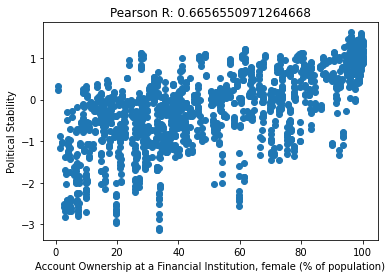

In [53]:
#get all correlations from filled_df_new dataframe
correlations = filled_df_new.corr()
#Select top 3 positive and negative correlations with political stability
top_3_pos_corrs = correlations['Political_Stability'].sort_values(ascending=False).head(4)
top_3_neg_corrs = correlations['Political_Stability'].sort_values(ascending=True).head(4)

#print out top correlations
print(top_3_pos_corrs)
print(top_3_neg_corrs)

#Set best_corr_value
best_corr_value = filled_df_new['Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)'].corr(filled_df_new['Political_Stability'])

#graph top correlation
#set x and y for scatterplot
x = filled_df_new['Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)']
y = filled_df_new['Political_Stability']

#Use scatterplot
plt.scatter(x, y)
#add title
plt.title('Pearson R: ' + str(best_corr_value))
plt.xlabel("Account Ownership at a Financial Institution, female (% of population)")
plt.ylabel("Political Stability")
plt.show()

Text(0.5, 1.0, 'Pearson R: 0.6656550971264668')

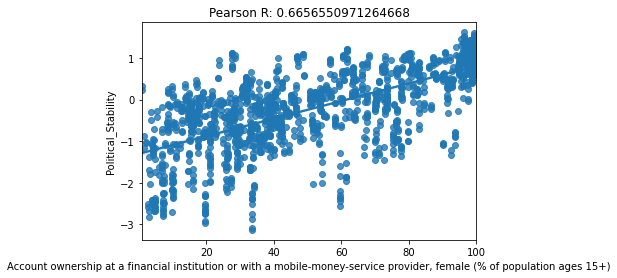

In [54]:
#Make plot using Seaborn which adds best fit line
import seaborn as sns
sns.regplot(x='Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)',
           y='Political_Stability', data=filled_df_new).set_title('Pearson R: ' + str(best_corr_value))

# Find Features that are correlated with each other and drop features 

In [55]:
#make a copy of filled_df_new
corr_filled_df = filled_df_new.copy()
corr_filled_df.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","New business density (new registrations per 1,000 people ages 15-64)",Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,-1.194900,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,7.160685,0.154862,11.447688,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,0.064764,56.254749,43.019718,NaN,0.64169,53.075142,NaN,0.21,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,7.160685,0.130028,11.447688,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,-0.541416,56.254749,43.019718,NaN,0.64567,50.694069,NaN,0.21,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4

In [56]:
#Find column pairs where correlation is greater than 0.8 and fill in missing values using the correlated column
for i in range(len(filled_df_new.columns)):
    for j in range(i):
        corr=filled_df_new[filled_df_new.columns[i]].corr(filled_df_new[filled_df_new.columns[j]])
        if corr > 0.7:
            col1_vals = filled_df_new[filled_df_new.columns[i]].values
            col2_vals = filled_df_new[filled_df_new.columns[j]].values
            for index1, col1_val in enumerate(col1_vals):
                if np.isnan(col1_val) and not np.isnan(col2_vals[index1]):
                    for index2, col2_val in enumerate(col2_vals):
                        if abs(col2_val-col2_vals[index1]) < (0.1*col2_vals[index1]) and not np.isnan(col1_vals[index2]) and index2 != index1:
                            col1_val = col1_vals[index2] 
            corr_filled_df[corr_filled_df.columns[i]] = col1_vals.tolist()

corr_filled_df.head()
                    

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","New business density (new registrations per 1,000 people ages 15-64)",Individuals using the Internet (% of population),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),GDP per capita growth (annual %),"Literacy rate, youth female (% of females ages 15-24)","Literacy rate, adult total (% of people ages 15 and above)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","Lower secondary completion rate, total (% of relevant age group)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality rate, under-5 (per 1,000 live births)","Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Mortality rate, neonatal (per 1,000 live births)",People using at least basic drinking water services (% of population),"Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,97.700000,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,1.535637,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,42.6,60.3,35.3,35.9,67.064623,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,98.715622,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,7.160685,0.211648,11.447688,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,-1.194900,56.254749,43.019718,NaN,0.63602,55.346420,NaN,0.21,41.8,62.5,35.4,36.9,67.064623,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,97.700000,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,7.160685,0.154862,11.447688,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,0.064764,56.254749,43.019718,NaN,0.64169,53.075142,NaN,0.21,40.9,64.9,35.5,38.0,67.064623,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,97.700000,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,7.160685,0.130028,11.447688,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,-0.541416,56.254749,43.019718,NaN,0.64567,50.694069,NaN,0.21,40.2,67.6,35.6,39.1,64.286484,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4

In [57]:
#Find the number of null values per feature
corr_filled_df.isnull().sum()

country                                                                                                                      0
Forest area (% of land area)                                                                                                31
Cereal yield (kg per hectare)                                                                                              208
Current account balance (% of GDP)                                                                                         168
Foreign direct investment, net inflows (% of GDP)                                                                           88
Net official development assistance and official aid received (current US$)                                                578
Access to clean fuels and technologies for cooking (% of population)                                                       160
Access to electricity (% of population)                                                                        

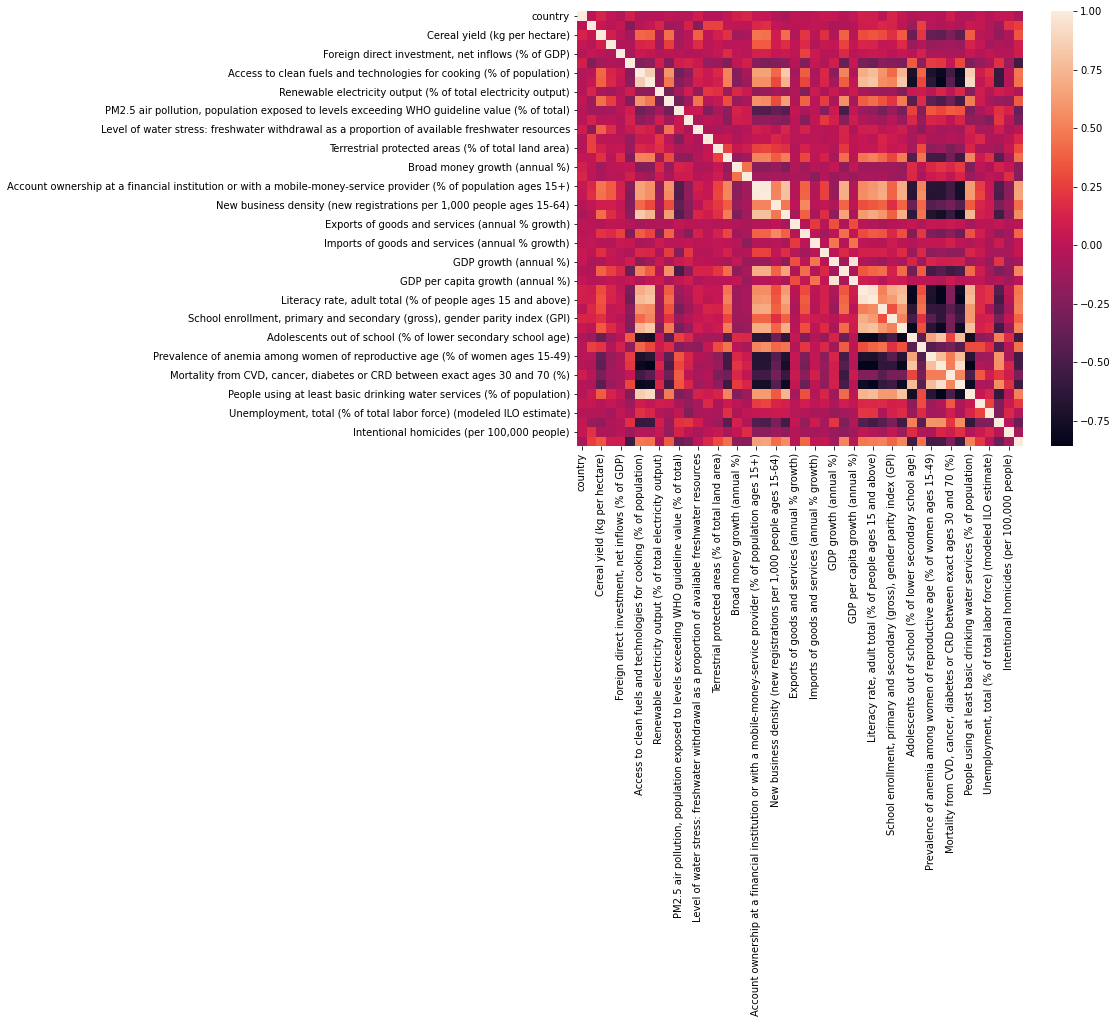

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

#Create Correlation Matrix
CorrMatrix = filled_df_new.corr()

plt.figure(figsize=(10,8))
sns.heatmap(CorrMatrix)
plt.show()

/var/folders/wl/3_8f_rss4bv4jf0by7yn790m0000gn/T/ipykernel_39081/3999998624.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_matrix = CorrMatrix.where(np.triu(np.ones(CorrMatrix.shape),k=1).astype(np.bool))


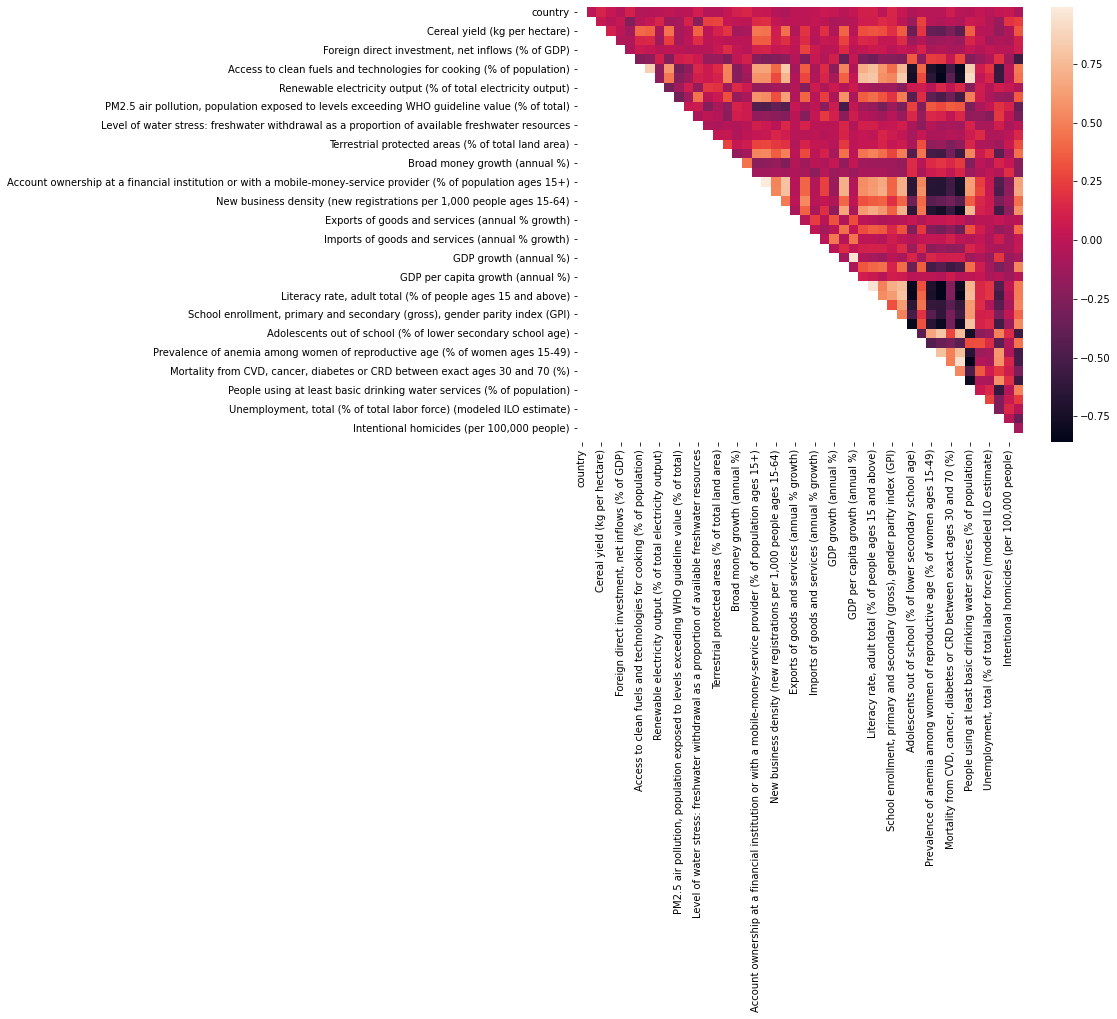

In [59]:
#Drop one feature if there is a high correlation
#import datasets from sklearn
from sklearn import datasets

#Get upper triangle of the correlation matrix since the bottom triangle is the same
upper_matrix = CorrMatrix.where(np.triu(np.ones(CorrMatrix.shape),k=1).astype(np.bool))

plt.figure(figsize=(10,8))
sns.heatmap(upper_matrix)
plt.show()


In [60]:
#Identify columns to drop where the correlation is greater than 0.8
to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.8)]
print(to_drop)

['Access to electricity (% of population)', 'Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)', 'Individuals using the Internet (% of population)', 'GDP per capita growth (annual %)', 'Literacy rate, adult total (% of people ages 15 and above)', 'Lower secondary completion rate, total (% of relevant age group)', 'Mortality rate, under-5 (per 1,000 live births)', 'Mortality rate, neonatal (per 1,000 live births)', 'People using at least basic drinking water services (% of population)']


In [61]:
#Drop the highly correlated columns from filled_df_new
df_uncorr = corr_filled_df.drop(to_drop, axis=1)
df_uncorr.head()

,country,Forest area (% of land area),Cereal yield (kg per hectare),Current account balance (% of GDP),"Foreign direct investment, net inflows (% of GDP)",Net official development assistance and official aid received (current US$),Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Urban population growth (annual %),"Intentional homicides (per 100,000 people)",Political_Stability
0,1,1.850994,2164.9,-19.656393,0.121323,4.284420e+09,32.44,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.87,5.704360,2.302373,14.893312,0.211648,NaN,NaN,NaN,1.929110e+10,3.911603,507.103392,56.254749,NaN,0.63602,NaN,0.21,42.6,35.3,4.1,10.98,3.323827,6.655561,-2.649407
1,1,1.850994,2164.9,-21.231682,0.650735,3.792450e+09,32.44,86.050111,0.200151,100.0,11.0,54.757019,1299.037244,0.104707,1.96,2.574154,0.626149,14.893312,0.211648,NaN,NaN,NaN,1.835388e+10,1.189228,493.756581,56.254749,NaN,0.63602,NaN,0.21,41.8,35.4,4.1,11.06,3.349934,6.655561,-2.751611
2,1,1.850994,2025.1,-18.838941,0.273100,3.811740e+09,32.44,86.050111,0.203328,100.0,11.0,54.757019,1299.037244,0.104707,2.04,4.093275,4.975952,14.893312,0.154862,NaN,NaN,NaN,1.886995e+10,2.647003,519.888913,56.254749,NaN,0.64169,NaN,0.21,40.9,35.5,4.1,11.18,3.462893,6.678401,-2.800609
3,1,1.850994,1981.9,-15.032194,0.519440,4.069420e+09,32.44,86.050111,0.208857,100.0,11.0,54.757019,1299.037244,0.100000,2.11,9.725428,4.383892,14.893312,0.130028,NaN,NaN,NaN,1.801775e+10,2.260314,509.220100,56.254749,NaN,0.64567,NaN,0.21,40.2,35.6,4.0,11.31,3.649128,6.551163,-2.671054
4,1,1.850994,2133.7,-21.061903,0.849679,4.274230e+09,30.10,86.050111,0.232176,100.0,11.0,54.757019,1299.037244,0.100000,2.16,3.079022,-0.661709,14.893312,0.124470,NaN,NaN,NaN,1.990711e+10,1.451315,578.466353,56.254749,NaN,0.64233,NaN,0.21,39.4,35.6,4.0,11.39,3.951726,9.783922,-2.571222


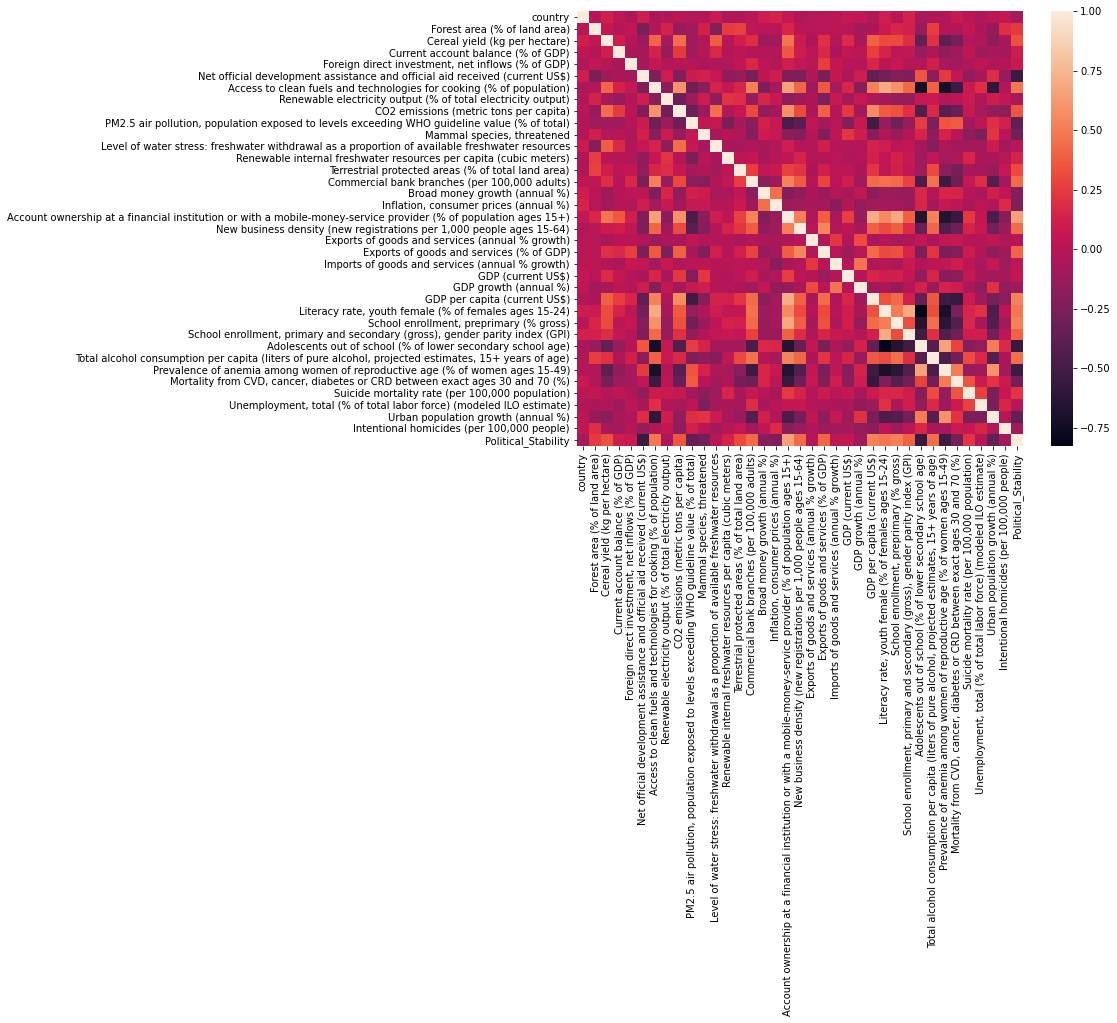

In [62]:
#Look at new correlation Matrix
new_corr_matrix = df_uncorr.corr()

plt.figure(figsize=(10,8))
sns.heatmap(new_corr_matrix)
plt.show()

# Use Unsupervised Learning to fill in remaining missing values after Clustering like countries

In [63]:
print(df_uncorr.shape)
#drop rows with more than 30% of the features missing in that row
threshold=0.7*df_uncorr.shape[1]
print(threshold)
mod_df = df_uncorr.dropna(axis=0, thresh=threshold)

print(mod_df.shape)
#print(mod_df['country'].value_counts())

(1927, 37)
25.9
(1769, 37)


In [64]:
#Find the number of null values per feature
mod_df.isnull().sum()

country                                                                                                              0
Forest area (% of land area)                                                                                         0
Cereal yield (kg per hectare)                                                                                       90
Current account balance (% of GDP)                                                                                  80
Foreign direct investment, net inflows (% of GDP)                                                                   20
Net official development assistance and official aid received (current US$)                                        450
Access to clean fuels and technologies for cooking (% of population)                                                40
Renewable electricity output (% of total electricity output)                                                         0
CO2 emissions (metric tons per capita)          

In [65]:
#A couple of columns still have high values for missing data, so we can drop those
new_drop_cols = ['Net official development assistance and official aid received (current US$)']
mod_df.drop(new_drop_cols, axis=1, inplace=True)
mod_df.shape

/Applications/anaconda3/envs/geowork/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(1769, 36)

In [66]:
#remove features that have a lot of missing values that we want to fill in later using unsupervised learning
cols_to_impute = ['Cereal yield (kg per hectare)', 'Current account balance (% of GDP)', 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources', 'Renewable internal freshwater resources per capita (cubic meters)', 'Broad money growth (annual %)', 'Inflation, consumer prices (annual %)', 'Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)', 'New business density (new registrations per 1,000 people ages 15-64)', 'Exports of goods and services (annual % growth)', 'Exports of goods and services (% of GDP)', 'Imports of goods and services (annual % growth)', 'Literacy rate, youth female (% of females ages 15-24)', 'School enrollment, preprimary (% gross)', 'School enrollment, primary and secondary (gross), gender parity index (GPI)', 'Adolescents out of school (% of lower secondary school age)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)', 'Intentional homicides (per 100,000 people)']
df_cols_to_impute = mod_df[cols_to_impute]
df_cols_to_impute.head()

#set the features for the unsupervised learning model
features = mod_df.drop(cols_to_impute, axis=1)
features.drop('Political_Stability', axis=1, inplace=True)
features.drop('country', axis=1, inplace=True)

#set the target for the unsupervised learning model
y = mod_df['country']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: country, dtype: int64

In [67]:
#fill in missing values in the features df with mean of column values
features.fillna(features.mean(), inplace=True)

In [68]:
#make sure there are no missing values
features.isnull().sum()

Forest area (% of land area)                                                                            0
Foreign direct investment, net inflows (% of GDP)                                                       0
Access to clean fuels and technologies for cooking (% of population)                                    0
Renewable electricity output (% of total electricity output)                                            0
CO2 emissions (metric tons per capita)                                                                  0
PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)            0
Mammal species, threatened                                                                              0
Terrestrial protected areas (% of total land area)                                                      0
Commercial bank branches (per 100,000 adults)                                                           0
GDP (current US$)                             

In [69]:
#standardize the dataset
from sklearn.preprocessing import StandardScaler

#Standardize the dataset
sc = StandardScaler()
features_sc = sc.fit_transform(features)

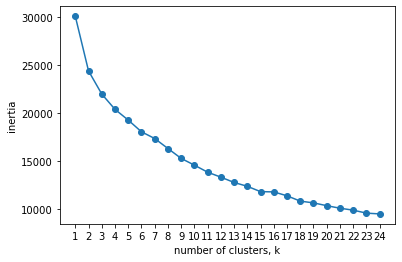

In [70]:
#Perform k-Means to cluster the data

#Find number of clusters using inertia
from sklearn.cluster import KMeans

ks = range(1, 25)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(features_sc)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [71]:
#set number of clusters to 11 using inertia elbow method
from sklearn.cluster import KMeans
model = KMeans(n_clusters=11)
labels = model.fit_predict(features_sc)

In [72]:
#add cluster label to features dataset
features['cluster_label']=labels.tolist()
features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),cluster_label
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,8
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,8
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,8
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,8
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,8


In [73]:
#join features dataset with df_cols_to_impute
final_features = pd.concat([features,df_cols_to_impute], axis=1)
final_features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),cluster_label,Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,8,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,0.211648,NaN,NaN,NaN,56.254749,NaN,0.63602,NaN,10.98,6.655561
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,8,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,0.211648,NaN,NaN,NaN,56.254749,NaN,0.63602,NaN,11.06,6.655561
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,8,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,0.154862,NaN,NaN,NaN,56.254749,NaN,0.64169,NaN,11.18,6.678401
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,8,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,0.130028,NaN,NaN,NaN,56.254749,NaN,0.64567,NaN,11.31,6.551163
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,8,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,0.124470,NaN,NaN,NaN,56.254749,NaN,0.64233,NaN,11.39,9.783922


In [74]:
#Group by label and fill missing values using mean of each group for each feature
filled_final_features = final_features.groupby("cluster_label").transform(lambda x: x.fillna(x.mean()))
filled_final_features.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"New business density (new registrations per 1,000 people ages 15-64)",Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,0.211648,6.503857,28.233306,7.621754,56.254749,33.505913,0.63602,27.136026,10.98,6.655561
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,0.211648,6.503857,28.233306,7.621754,56.254749,33.505913,0.63602,27.136026,11.06,6.655561
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,0.154862,6.503857,28.233306,7.621754,56.254749,33.505913,0.64169,27.136026,11.18,6.678401
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,0.130028,6.503857,28.233306,7.621754,56.254749,33.505913,0.64567,27.136026,11.31,6.551163
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,0.124470,6.503857,28.233306,7.621754,56.254749,33.505913,0.64233,27.136026,11.39,9.783922


In [75]:
#make sure there are no missing values
filled_final_features.isnull().sum()

Forest area (% of land area)                                                                                        0
Foreign direct investment, net inflows (% of GDP)                                                                   0
Access to clean fuels and technologies for cooking (% of population)                                                0
Renewable electricity output (% of total electricity output)                                                        0
CO2 emissions (metric tons per capita)                                                                              0
PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)                        0
Mammal species, threatened                                                                                          0
Terrestrial protected areas (% of total land area)                                                                  0
Commercial bank branches (per 100,000 adults)           

In [76]:
#New business density column must have had all null values for one cluster, so it was unable to be filled in. Since that had a large number of missing values earlier, let's drop that column. 
filled_final_features.drop('New business density (new registrations per 1,000 people ages 15-64)', axis=1, inplace=True)

In [77]:
filled_final_df = filled_final_features.copy()

In [78]:
filled_final_df['Political_Stability'] = mod_df['Political_Stability']

In [79]:
filled_final_df.Political_Stability = filled_final_df.Political_Stability.astype(float)

In [80]:
filled_final_df.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)",Political_Stability
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.63602,27.136026,10.98,6.655561,-2.649407
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.63602,27.136026,11.06,6.655561,-2.751611
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.64169,27.136026,11.18,6.678401,-2.800609
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.64567,27.136026,11.31,6.551163,-2.671054
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.64233,27.136026,11.39,9.783922,-2.571222


# Supervised Learning Models

## Mutiple Linear Regression Model

In [81]:
#Set X and y for the models
X = filled_final_df.drop('Political_Stability', axis=1)
print(X.shape)
y = filled_final_df['Political_Stability'].values.reshape(-1,1)
print(y.shape)

#import train test split
from sklearn.model_selection import train_test_split

#split the dataset into testing and training portions, with the testing portion making up 20% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

(1769, 33)
(1769, 1)


In [82]:
from sklearn.preprocessing import StandardScaler

#Standardize the dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [83]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
mse_model = MSE(y_test, y_pred)
rmse_model = mse_model**(1/2)
print("Linear Regression RMSE_Model = ", rmse_model)

#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('Linear Regression R2 Score = ' , r2)

Linear Regression RMSE_Model =  0.6196268426321236
Linear Regression R2 Score =  0.5135248743569285


## Decision Tree Regressor

In [84]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
mse_model = MSE(y_test, y_pred)
rmse_model = mse_model**(1/2)
print("Decision Tree Regression RMSE_Model = ", rmse_model)

#calculate r2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('Decision Tree Regression R2 Score = ' , r2)

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

Decision Tree Regression RMSE_Model =  0.5926838011700868
Decision Tree Regression R2 Score =  0.5549115677551077
Decision Tree Mean Absolute Error = 1.11


In [85]:
#Tune Decision Tree Regressor
#get parameters of model
dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [86]:
#Tune the model to reduce error

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the grid of hyperparameters 'params_dt'
params_dt = {'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],'min_samples_leaf': [0.005, 0.01, 0.02, 0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8, 0.1, 0.2]}

# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dtr,param_grid=params_dt, cv=10, n_jobs=-1)

# Fit 'grid_dt' to the training data
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 0.1, 0.2],
                         'min_samples_leaf': [0.005, 0.01, 0.02, 0.04, 0.06,
                                              0.08]})

In [87]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 12, 'max_features': 0.6, 'min_samples_leaf': 0.005}


In [88]:
#fit the model again with the best parameters
dtr = DecisionTreeRegressor(max_depth=11, max_features=0.8, min_samples_leaf=0.005, random_state=42)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Tuned Decision Tree RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Tuned Decision Tree R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Tuned Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

Tuned Decision Tree RMSE_Model =  0.59
Tuned Decision Tree R2 Score =  0.58
Tuned Decision Tree Mean Absolute Error = 1.08


Feature: 0, Score: 0.10287
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00388
Feature: 3, Score: 0.00404
Feature: 4, Score: 0.03235
Feature: 5, Score: 0.00301
Feature: 6, Score: 0.09447
Feature: 7, Score: 0.02700
Feature: 8, Score: 0.01529
Feature: 9, Score: 0.00898
Feature: 10, Score: 0.00001
Feature: 11, Score: 0.00653
Feature: 12, Score: 0.00036
Feature: 13, Score: 0.02894
Feature: 14, Score: 0.00465
Feature: 15, Score: 0.08188
Feature: 16, Score: 0.01339
Feature: 17, Score: 0.00103
Feature: 18, Score: 0.00147
Feature: 19, Score: 0.00275
Feature: 20, Score: 0.03271
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00043
Feature: 23, Score: 0.40131
Feature: 24, Score: 0.00001
Feature: 25, Score: 0.03285
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.01579
Feature: 28, Score: 0.02191
Feature: 29, Score: 0.03542
Feature: 30, Score: 0.00240
Feature: 31, Score: 0.01777
Feature: 32, Score: 0.00650


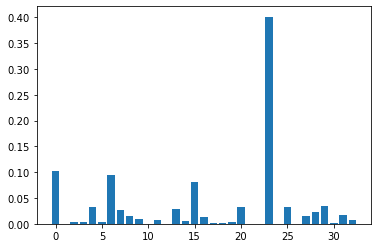

In [89]:
#Find what features are the most important for this model
importance = dtr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [90]:
#Show column name for most important columns
print(X.columns[23])
print(X.columns[30])
print(X.columns[6])
print(X.columns[19])

Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)
Adolescents out of school (% of lower secondary school age)
Mammal species, threatened
Level of water stress: freshwater withdrawal as a proportion of available freshwater resources


## Random Forest Regressor

In [91]:
#import model
from sklearn.ensemble import RandomForestRegressor

#Instantiate a Random Forest Regessor
rf = RandomForestRegressor(n_estimators=10, random_state=42)

# Fit the model to the training set
rf.fit(X_train, y_train)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Tuned Random Forest Regression RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Tuned Random Forest Regression R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Tuned Random Forest Regression Mean Absolute Error =', round(np.mean(errors), 2))

/var/folders/wl/3_8f_rss4bv4jf0by7yn790m0000gn/T/ipykernel_39081/2038945613.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Tuned Random Forest Regression RMSE_Model =  0.59
Tuned Random Forest Regression R2 Score =  0.76
Tuned Random Forest Regression Mean Absolute Error = 0.93


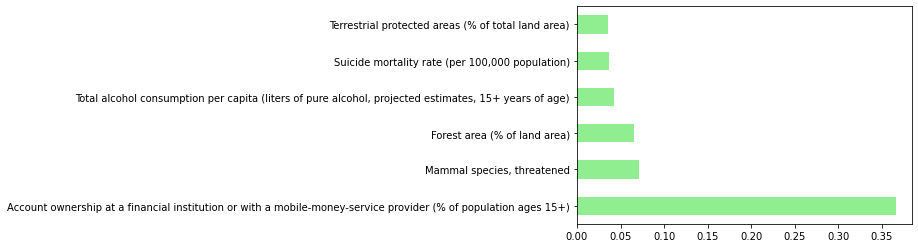

In [92]:
#Look at feature importances for this model
new_df = pd.DataFrame(X, X.columns)

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = new_df.columns)
# Sort importances_rf        
sorted_importances_rf = importances_rf.sort_values(ascending=False) 
#Only save top five important features
top_sorted_importances_rf = sorted_importances_rf[0:6]
# Make a horizontal bar plot
top_sorted_importances_rf.plot(kind='barh', color='lightgreen') 
plt.show()

In [93]:
#Get parameters for the Random Forest Regressor
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [94]:
#tune the model

#import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2','auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs=None)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
#Rerun the models with the selected best parameters
#Instantiate a Random Forest Regessor
rf = RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=False, random_state=42)

# Fit the model to the training set
rf.fit(X_train, y_train)

# Predict the test set labels
y_pred = rf.predict(X_test)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("Random Forest Regression RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('Random Forest Regression R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('Random Forest Regression Mean Absolute Error =', round(np.mean(errors), 2))

In [ ]:
#Use a function to see how much the best parameters improved the model from its base state with 10 estimators and all default parameters.
def evaluate(rf, X_test, y_test):
    y_pred = rf.predict(X_test)
    errors = abs(y_pred - y_test)
    mae = round(np.mean(errors),2)
    print('Mean Absolute Error = ', round(mae,2))
    
    return mae


base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_mae = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_mae = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (base_mae - random_mae) / base_accuracy))

In [96]:
#Create a dataframe of the feature importances
rf_features_df = pd.DataFrame(rf.feature_importances_, X.columns)
rf_features_df.head()

,0
Forest area (% of land area),0.064907
"Foreign direct investment, net inflows (% of GDP)",0.006438
Access to clean fuels and technologies for cooking (% of population),0.022392
Renewable electricity output (% of total electricity output),0.007301
CO2 emissions (metric tons per capita),0.009630


In [97]:
rf_features_df.sort_values(by=0, ascending=False)

,0
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),0.365929
"Mammal species, threatened",0.071613
Forest area (% of land area),0.064907
"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",0.042697
"Suicide mortality rate (per 100,000 population)",0.037189
Terrestrial protected areas (% of total land area),0.036032
"Commercial bank branches (per 100,000 adults)",0.034839
"Literacy rate, youth female (% of females ages 15-24)",0.029694
GDP (current US$),0.028132
Adolescents out of school (% of lower secondary school age),0.025984


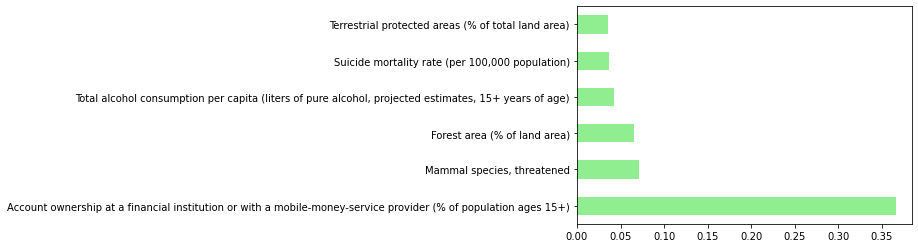

In [98]:
#Look at feature importances for this model

# Create a pd.Series of features importances
importances_rf_tuned = pd.Series(rf.feature_importances_, index=new_df.columns)
# Sort importances_rf        
sorted_importances_rf = importances_rf_tuned.sort_values(ascending=False) 
#Only save top five important features
top_sorted_importances_rf = sorted_importances_rf[0:6]
# Make a horizontal bar plot
top_sorted_importances_rf.plot(kind='barh', color='lightgreen') 
plt.show()

# PCA

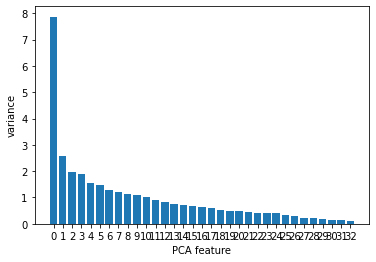

In [99]:
#import PCA
from sklearn.decomposition import PCA

#find the 
pca = PCA()

#train the model
pca.fit(X_train)

#find the intrinsic dimension of the dataset
features = range(pca.n_components_)

#graph variance in each feature
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

In [100]:
# Perform Dimension Reduction with PCA
pca = PCA(n_components=4)

X_train_pca=pca.fit(X_train)
X_test_pca=pca.fit(X_test)

X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

#fit the decision tree model with the PCA transformed data
dtpca = DecisionTreeRegressor(max_depth=11, max_features=0.8, min_samples_leaf=0.005, random_state=42).fit(X_train_transformed, y_train)

In [101]:
#make predictions with the model
y_pred = dtpca.predict(X_test_transformed)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("PCA Decision Tree RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('PCA Decision Tree R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('PCA Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

PCA Decision Tree RMSE_Model =  0.59
PCA Decision Tree R2 Score =  0.42
PCA Decision Tree Mean Absolute Error = 0.95


In [102]:
#tune the decision tree with the PCA transformed data

# Define the grid of hyperparameters 'params_dt'
params_dt = {'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],'min_samples_leaf': [0.001, 0.005, 0.01, 0.02, 0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8, 0.1, 0.2]}

# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dtpca,param_grid=params_dt, cv=10, n_jobs=-1)

# Fit 'grid_dt' to the training data
grid_dt.fit(X_train_transformed, y_train)

GridSearchCV(cv=10,
             estimator=DecisionTreeRegressor(max_depth=11, max_features=0.8,
                                             min_samples_leaf=0.005,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10, 11, 12, 13, 14, 15],
                         'max_features': [0.2, 0.4, 0.6, 0.8, 0.1, 0.2],
                         'min_samples_leaf': [0.001, 0.005, 0.01, 0.02, 0.04,
                                              0.06, 0.08]})

In [103]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'max_depth': 8, 'max_features': 0.8, 'min_samples_leaf': 0.005}


In [104]:
#fit the decision tree model with the PCA transformed data
dtpca_tuned = DecisionTreeRegressor(max_depth=9, max_features=0.8, min_samples_leaf=0.005, random_state=42).fit(X_train_transformed, y_train)

#make predictions with the model
y_pred = dtpca_tuned.predict(X_test_transformed)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("PCA Decision Tree RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('PCA Decision Tree R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('PCA Decision Tree Mean Absolute Error =', round(np.mean(errors), 2))

PCA Decision Tree RMSE_Model =  0.59
PCA Decision Tree R2 Score =  0.42
PCA Decision Tree Mean Absolute Error = 0.93


## Random Forest Regressor with PCA

In [105]:
#Instantiate a Random Forest Regessor
rf = RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=20, bootstrap=False, random_state=42)

# Fit the model to the training set
rf.fit(X_train_transformed, y_train)

# Predict the test set labels
y_pred = rf.predict(X_test_transformed)

# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("PCA Random Forest Regression MSE_Model = ", round(rmse_model, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('PCA Random Forest Regression R2 Score = ' , round(r2, 2))

#Get mean absolute error
errors = abs(y_pred - y_test)
print('PCA Random Forest Regression Mean Absolute Error =', round(np.mean(errors), 2))

/var/folders/wl/3_8f_rss4bv4jf0by7yn790m0000gn/T/ipykernel_39081/4074377319.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_transformed, y_train)


PCA Random Forest Regression MSE_Model =  0.59
PCA Random Forest Regression R2 Score =  0.59
PCA Random Forest Regression Mean Absolute Error = 0.91


For both Random Forest and Decision PCA made the model results worse.  

## Neural Network (PyTorch)

In [106]:
#Set X and y for the models
X = filled_final_df.drop('Political_Stability', axis=1).values
y = filled_final_df['Political_Stability'].values.reshape(-1,1)

#split the dataset into testing and training portions, with the testing portion making up 20% of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [107]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F #this has activation functions

# Creating tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

print(X_train)

tensor([[ 2.6122,  2.0776,  0.2823,  ..., -0.4312,  1.0635,  0.5669],
        [ 1.5359, -0.3570,  0.9635,  ..., -0.6802, -0.8608, -0.6450],
        [ 0.9790,  0.0395, -1.2570,  ..., -0.2935,  0.9145, -0.3845],
        ...,
        [ 1.6977, -0.0747, -1.5557,  ...,  0.8224, -1.2384, -0.1677],
        [ 0.4226,  0.2780,  0.9635,  ..., -0.0561,  0.8713,  2.4561],
        [ 0.2132, -0.3888,  0.9635,  ..., -0.7353, -0.3464, -0.5777]])


In [109]:
class ANN_Model(nn.Module):
    def __init__(self, input_features=33, hidden1=33, hidden2=33, out_features=1):
        super().__init__()
        self.layer_1_connection = nn.Linear(input_features, hidden1)
        self.layer_2_connection = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, out_features)
    
    def forward(self, x):
        #apply activation functions
        x = F.relu(self.layer_1_connection(x))
        x = F.relu(self.layer_2_connection(x))
        x = self.out(x)
        return x

In [110]:
torch.manual_seed(42)

#instantiate the model
ann_model = ANN_Model()

In [111]:
# loss function
loss_function = nn.MSELoss()

#optimizer
optimizer = torch.optim.Adam(ann_model.parameters(), lr = 0.01)

In [112]:
#run model through multiple epochs/iterations
final_loss = []
n_epochs = 500
for epoch in range(n_epochs):
    y_pred = ann_model.forward(X_train)
    loss = loss_function(y_pred, y_train)
    final_loss.append(loss)
    
    if epoch % 10 == 1:
        print(f'Epoch number: {epoch} with loss: {loss.item()}')
    
    optimizer.zero_grad() #zero the gradient before running backwards propagation
    loss.backward() #for backward propagation 
    optimizer.step() #performs one optimization step each epoch

Epoch number: 1 with loss: 0.7279764413833618
Epoch number: 11 with loss: 0.3304426074028015
Epoch number: 21 with loss: 0.2353210598230362
Epoch number: 31 with loss: 0.1778157502412796
Epoch number: 41 with loss: 0.1286131888628006
Epoch number: 51 with loss: 0.09383364021778107
Epoch number: 61 with loss: 0.0681823268532753
Epoch number: 71 with loss: 0.055302031338214874
Epoch number: 81 with loss: 0.040553104132413864
Epoch number: 91 with loss: 0.0336446687579155
Epoch number: 101 with loss: 0.02882968634366989
Epoch number: 111 with loss: 0.025678569450974464
Epoch number: 121 with loss: 0.025640109553933144
Epoch number: 131 with loss: 0.022419076412916183
Epoch number: 141 with loss: 0.019485631957650185
Epoch number: 151 with loss: 0.018149716779589653
Epoch number: 161 with loss: 0.01881248690187931
Epoch number: 171 with loss: 0.01563575305044651
Epoch number: 181 with loss: 0.014401832595467567
Epoch number: 191 with loss: 0.014147466979920864
Epoch number: 201 with loss: 

In [113]:
#predictions
y_pred = []

with torch.no_grad():
    for i, data in enumerate(X_test):
        prediction = ann_model(data)
        y_pred.append(prediction.argmax().item())

In [114]:
# Calculate the root mean square error
rmse = MSE(y_test, y_pred)**(1/2)
print("PyTorch Neural Network RMSE_Model = ", round(rmse_model, 2))

#Get r2 score
r2 = r2_score(y_test, y_pred)
print('PyTorch Neural Network R2 Score = ' , round(r2, 2))

PyTorch Neural Network RMSE_Model =  0.59
PyTorch Neural Network R2 Score =  -0.01


# Look at Prediction of Political Stability Using the 5-year change in each Sustainability Variable

In [115]:
#Append Country to filled_final_features
final_with_country = filled_final_features.copy()
final_with_country['country'] = mod_df['country'].copy()
final_with_country.head()

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)",country
0,1.850994,0.121323,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.87,1.929110e+10,3.911603,507.103392,0.21,42.6,35.3,4.1,3.323827,2164.9,-19.656393,54.757019,1299.037244,5.704360,2.302373,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.63602,27.136026,10.98,6.655561,1
1,1.850994,0.650735,32.44,86.050111,0.200151,100.0,11.0,0.104707,1.96,1.835388e+10,1.189228,493.756581,0.21,41.8,35.4,4.1,3.349934,2164.9,-21.231682,54.757019,1299.037244,2.574154,0.626149,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.63602,27.136026,11.06,6.655561,1
2,1.850994,0.273100,32.44,86.050111,0.203328,100.0,11.0,0.104707,2.04,1.886995e+10,2.647003,519.888913,0.21,40.9,35.5,4.1,3.462893,2025.1,-18.838941,54.757019,1299.037244,4.093275,4.975952,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.64169,27.136026,11.18,6.678401,1
3,1.850994,0.519440,32.44,86.050111,0.208857,100.0,11.0,0.100000,2.11,1.801775e+10,2.260314,509.220100,0.21,40.2,35.6,4.0,3.649128,1981.9,-15.032194,54.757019,1299.037244,9.725428,4.383892,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.64567,27.136026,11.31,6.551163,1
4,1.850994,0.849679,30.10,86.050111,0.232176,100.0,11.0,0.100000,2.16,1.990711e+10,1.451315,578.466353,0.21,39.4,35.6,4.0,3.951726,2133.7,-21.061903,54.757019,1299.037244,3.079022,-0.661709,14.893312,6.503857,28.233306,7.621754,56.254749,33.505913,0.64233,27.136026,11.39,9.783922,1


In [116]:
#Count number of unique values for each country to make sure it is 10 years for each country
final_with_country['country'].value_counts()
#This is true for all but one country: 159 (South Sudan) which has 9 years

#Group by the country and find the five-year difference 
five_year_change_df = final_with_country.groupby(['country']).diff(periods=5)
five_year_change_df.head(20)

,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000,0.088467,-4.45,-0.726562,0.033886,0.000000e+00,0.0,-0.004707,0.43,1.193781e+09,-1.187060,106.753113,0.00,-3.9,0.4,-0.2,0.905964,-147.4,3.874546,0.000000,0.000000,2.431211,2.371624,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01800,0.00000,0.47,3.128361
6,0.000000,-0.415770,-6.27,-7.413703,0.063565,0.000000e+00,0.0,-0.004707,0.29,2.207188e+09,4.411517,143.408883,0.00,-3.8,0.8,-0.1,1.022420,-116.4,-3.548355,0.000000,0.000000,7.340330,6.759623,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01931,0.00000,0.48,3.128361
7,0.000000,0.010995,-8.36,-0.140131,0.132023,0.000000e+00,0.0,-0.004707,0.09,1.131653e+09,10.105284,121.982525,0.00,-3.4,1.1,-0.1,0.826058,4.5,-6.909810,0.000000,214.053737,4.634454,1.465261,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.02756,0.00000,0.34,-0.427073
8,0.000000,-0.226401,-10.11,-3.562549,0.198216,0.000000e+00,0.0,0.000000,0.11,-2.134561e+08,-1.833959,81.942698,0.00,-3.1,1.5,0.1,0.378960,-322.0,2.412085,0.000000,214.053737,11.583740,7.420294,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,0.01778,0.00000,0.20,-2.463827
9,0.000000,0.353446,-9.42,-0.063564,0.064890,0.000000e+00,0.0,0.000000,0.23,-4.050537e+09,12.911127,-35.163386,0.00,-2.6,2.2,0.3,-0.320727,-122.6,17.418567,0.000000,214.053737,23.868106,2.840247,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,-0.01652,0.00000,0.13,-6.415812


In [117]:
#Add Political Stability values to the dataframe
five_year_change_df['Political_Stability']=mod_df['Political_Stability'].copy()

In [118]:
#remove all rows with NaN values
five_year_change_df.dropna(inplace=True)
print(five_year_change_df.shape)
five_year_change_df.head(20)

(884, 34)


,Forest area (% of land area),"Foreign direct investment, net inflows (% of GDP)",Access to clean fuels and technologies for cooking (% of population),Renewable electricity output (% of total electricity output),CO2 emissions (metric tons per capita),"PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)","Mammal species, threatened",Terrestrial protected areas (% of total land area),"Commercial bank branches (per 100,000 adults)",GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Prevalence of anemia among women of reproductive age (% of women ages 15-49),"Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)","Suicide mortality rate (per 100,000 population)",Urban population growth (annual %),Cereal yield (kg per hectare),Current account balance (% of GDP),Level of water stress: freshwater withdrawal as a proportion of available freshwater resources,Renewable internal freshwater resources per capita (cubic meters),Broad money growth (annual %),"Inflation, consumer prices (annual %)",Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),Exports of goods and services (annual % growth),Exports of goods and services (% of GDP),Imports of goods and services (annual % growth),"Literacy rate, youth female (% of females ages 15-24)","School enrollment, preprimary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)",Adolescents out of school (% of lower secondary school age),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Intentional homicides (per 100,000 people)",Political_Stability
5,0.000000,0.088467,-4.45,-0.726562,0.033886,0.000000e+00,0.0,-0.004707,0.43,1.193781e+09,-1.187060,106.753113,0.00,-3.9,0.4,-0.2,0.905964,-147.4,3.874546,0.000000,0.000000,2.431211,2.371624,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01800,0.00000,0.47,3.128361,-2.411068
6,0.000000,-0.415770,-6.27,-7.413703,0.063565,0.000000e+00,0.0,-0.004707,0.29,2.207188e+09,4.411517,143.408883,0.00,-3.8,0.8,-0.1,1.022420,-116.4,-3.548355,0.000000,0.000000,7.340330,6.759623,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.01931,0.00000,0.48,3.128361,-2.519349
7,0.000000,0.010995,-8.36,-0.140131,0.132023,0.000000e+00,0.0,-0.004707,0.09,1.131653e+09,10.105284,121.982525,0.00,-3.4,1.1,-0.1,0.826058,4.5,-6.909810,0.000000,214.053737,4.634454,1.465261,-4.932312,0.000000,0.000000,0.000000,0.000000,0.000000,0.02756,0.00000,0.34,-0.427073,-2.418561
8,0.000000,-0.226401,-10.11,-3.562549,0.198216,0.000000e+00,0.0,0.000000,0.11,-2.134561e+08,-1.833959,81.942698,0.00,-3.1,1.5,0.1,0.378960,-322.0,2.412085,0.000000,214.053737,11.583740,7.420294,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,0.01778,0.00000,0.20,-2.463827,-2.502060
9,0.000000,0.353446,-9.42,-0.063564,0.064890,0.000000e+00,0.0,0.000000,0.23,-4.050537e+09,12.911127,-35.163386,0.00,-2.6,2.2,0.3,-0.320727,-122.6,17.418567,0.000000,214.053737,23.868106,2.840247,-5.888300,0.000000,0.000000,0.000000,-24.141529,0.000000,-0.01652,0.00000,0.13,-6.415812,-2.579152
15,-0.041460,0.836348,-3.44,0.000000,-0.132943,3.569767e-11,0.0,-0.526095,3.36,-2.058469e+09,-0.399206,-777.215801,-0.43,-2.4,2.1,0.7,0.574702,52.1,-2.802118,0.000000,0.000000,-0.300514,0.214774,-2.028816,-4.874386,-3.327237,1.263684,0.000000,7.595062,-0.04195,1.54485,6.59,1.750135,0.485986
16,-0.093412,1.865001,-5.64,0.000000,-0.285207,3.569767e-11,0.0,-0.526095,3.95,-2.370803e+09,-3.069314,-871.319323,-0.43,-2.6,2.0,0.8,0.426477,109.3,-2.604642,0.000000,0.000000,2.497112,-0.090439,-2.028816,-2.513878,-2.675220,-3.040613,0.000000,1.059608,-0.03571,2.36982,3.57,1.980792,0.091930
17,-0.145456,-0.404111,-7.46,0.000000,-0.369780,3.569767e-11,0.0,-0.526095,3.34,-6.998632e+08,-2.384671,-283.390822,-0.43,-2.6,2.2,0.5,0.307094,70.8,-2.655932,0.0444

In [119]:
#Find which feature has the highest correlation with Political Stability
#get all correlations from five_year_change_df dataframe
five_year_change_correlations = five_year_change_df.corr()
#elect top 3 positive and negative correlations with political stability
five_year_top_3_pos_corrs = five_year_change_correlations['Political_Stability'].sort_values(ascending=False).head(4)
five_year_top_3_neg_corrs = five_year_change_correlations['Political_Stability'].sort_values(ascending=True).head(4)

#print out top correlations
print(five_year_top_3_pos_corrs)
print(five_year_top_3_neg_corrs)

Political_Stability                                                                                                1.000000
Commercial bank branches (per 100,000 adults)                                                                      0.310333
Literacy rate, youth female (% of females ages 15-24)                                                              0.245291
Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)    0.236826
Name: Political_Stability, dtype: float64
Renewable electricity output (% of total electricity output)                   -0.194032
Terrestrial protected areas (% of total land area)                             -0.141528
Forest area (% of land area)                                                   -0.118681
Prevalence of anemia among women of reproductive age (% of women ages 15-49)   -0.113248
Name: Political_Stability, dtype: float64


0.3103332152636484


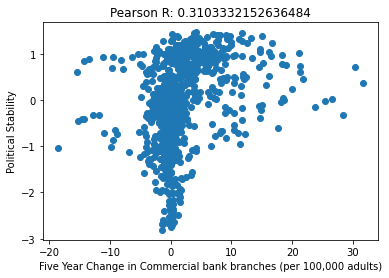

In [120]:
#Set best_corr_value
best_new_corr_value = five_year_change_df['Commercial bank branches (per 100,000 adults)'].corr(five_year_change_df['Political_Stability'])
print(best_new_corr_value)

#graph top correlation
#set x and y for scatterplot
x_five_year = five_year_change_df['Commercial bank branches (per 100,000 adults)']
y_five_year = five_year_change_df['Political_Stability']

#Use scatterplot
plt.scatter(x_five_year, y_five_year)
#add title
plt.title('Pearson R: ' + str(best_new_corr_value))
plt.xlabel("Five Year Change in Commercial bank branches (per 100,000 adults)")
plt.ylabel("Political Stability")
plt.show()

In [121]:
#There is not a strong correlation between the five-year change in each sustainability indicator and political stability score. 